In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from preprocessed_mnist import load_dataset
import time

### Define one-hot-encoding function

In [45]:
def one_hot_encoding(y):
    """
    Generate one-hot-ecoding for the labels:
    params: list of labels: y
    returns: numpy array of encoded labels of size [?,num_classes]
    
    """
    num_samples = y.shape[0]
    num_class = np.unique(y).shape[0]   
    
    y_encoded = np.zeros((num_samples,num_class))
    y_encoded[np.arange(num_samples),y] = 1

    return y_encoded

### Testing one-hot-encoding function

In [46]:
x = np.arange(0,4)
print('labels without one hot encoding: ',x)
x = one_hot_encoding(x)
print('labels after one hot encoding: ')
print(x)

labels without one hot encoding:  [0 1 2 3]
labels after one hot encoding: 
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


### Create random mini batches for training.

In [47]:
def random_minibatch(X,Y,batch_size):
    """
    creates random minibatches from the data of size batch_size each
    params: numpy array X (input data), numpy array Y (labels) and int batch_size 
    returns: list of tuples (of size 2) index 1: X and index 2: Y 
    
    """
    np.random.seed(1)
    
    assert X.shape[0] == Y.shape[0]
    
    num_samples = X.shape[0]
    
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # generate random permutation of indices.
    
    minibatches = []
    for idx in range(0,num_samples,batch_size):
        batch_indices = indices[idx:idx+batch_size]

        minibatches.append((X[batch_indices,] ,Y[batch_indices,]))
 
    return minibatches    

### Testing random_minibatch function

In [48]:
x = np.arange(0,20)
y = np.arange(0,20)

batches = random_minibatch(x,y,5)
error_flag = 0

for batch in batches:
    arr_x = batch[0]
    arr_y = batch[1]
    if not np.array_equal(arr_x,arr_y):
       error_flag = 1

if error_flag:
    print('Test Failed!')
else:
    print('Test Passed!')

Test Passed!


### Function defining model inputs for the tensorlfow graph

In [49]:
def create_model_inputs():
    """
    create inputs (placeholders) for the tensorflow graph
    params: none
    returns: 2 tensor objects used as inputs to tensorflow of shape [None, 28*28] and [None, 10]
    
    """
    X_in = tf.placeholder(dtype="float32",shape=[None,28*28]) 
    Y_in = tf.placeholder(dtype="float32",shape=[None,10])
    
    print(X_in.shape[0])
    
    return X_in,Y_in

### Checking model input shapes

In [50]:
create_model_inputs()

?


(<tf.Tensor 'Placeholder_8:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'Placeholder_9:0' shape=(?, 10) dtype=float32>)

### Creating a function which initializes weights for the neural network model.

In [51]:
def initialize_parameters():
    """
    initialize weights for the networks.
    params: none
    returns: dictionary of weights for the neural network. <key> : name , <value> : variable tensor 
    
    """
    
    tf.set_random_seed(3) # set random seed 

    neurons_layer_1 = 500
    neurons_layer_2 = 500
    neurons_layer_3 = 500
    neurons_layer_4 = 10
    

    init_w = tf.contrib.layers.xavier_initializer()  # weight initializer
    init_b = tf.constant_initializer(0.0)  # bias initializer 
    
    w1 = tf.get_variable("W1",[28*28,neurons_layer_1], initializer=init_w)
    b1 =  tf.get_variable("b1",neurons_layer_1,initializer=init_b)
    
    w2 = tf.get_variable("W2",[neurons_layer_1,neurons_layer_2], initializer=init_w)
    b2 =  tf.get_variable("b2",neurons_layer_2,initializer=init_b)
    
    w3 = tf.get_variable("W3",[neurons_layer_2,neurons_layer_3], initializer=init_w)
    b3 =  tf.get_variable("b3",neurons_layer_3,initializer=init_b)
    
    w4 = tf.get_variable("W4",[neurons_layer_3,neurons_layer_4], initializer=init_w)
    b4 =  tf.get_variable("b4",neurons_layer_4,initializer=init_b)
    
    
    parameters = {"w1" : w1, "b1" : b1,
                  "w2" : w2, "b2" : b2,
                  "w3" : w3, "b3" : b3,
                  "w4" : w4, "b4" : b4}
    
    return parameters

### Checking if model parameters are initialized properly

In [52]:
tf.reset_default_graph()
initialize_parameters()

{'b1': <tf.Variable 'b1:0' shape=(500,) dtype=float32_ref>,
 'b2': <tf.Variable 'b2:0' shape=(500,) dtype=float32_ref>,
 'b3': <tf.Variable 'b3:0' shape=(500,) dtype=float32_ref>,
 'b4': <tf.Variable 'b4:0' shape=(10,) dtype=float32_ref>,
 'w1': <tf.Variable 'W1:0' shape=(784, 500) dtype=float32_ref>,
 'w2': <tf.Variable 'W2:0' shape=(500, 500) dtype=float32_ref>,
 'w3': <tf.Variable 'W3:0' shape=(500, 500) dtype=float32_ref>,
 'w4': <tf.Variable 'W4:0' shape=(500, 10) dtype=float32_ref>}

#### Batch Normalization (Not used) Skip

In [53]:
def batch_norm(layer):
    """
    (unused function)
    Computes mean and variance for the layer inputs and outpus
    params: layer inputs (tensor object)
    returns: normalized layer inputs.
    """
    mean,variance = tf.nn.moments(layer,0)
    return tf.nn.batch_normalization(layer,mean,variance,offset=0.,scale=1.,variance_epsilon=1e-3)

### Fucntion defining forward Propagation in the neural network model.

In [54]:
def nn_forward_prop(X,parameters,keep_prob):
    """
    feed forward 4-layer mlp architecture 
    params: placeholder: X and Variables: parameters
    returns: tensor object (Dense): out
    """
    w1 , b1  = parameters["w1"] , parameters["b1"]
    w2 , b2  = parameters["w2"] , parameters["b2"]
    w3 , b3  = parameters["w3"] , parameters["b3"]
    w4 , b4  = parameters["w4"] , parameters["b4"]
    
    layer_1  = tf.matmul(X,w1) + b1
    activation_1 = tf.nn.relu(layer_1) 
    dropout_1 = tf.nn.dropout(activation_1,keep_prob)
    
    layer_2  = tf.matmul(dropout_1,w2) + b2
    activation_2 = tf.nn.relu(layer_2) 
    dropout_2 = tf.nn.dropout(activation_2,keep_prob)
    
    layer_3  = tf.matmul(dropout_2,w3) + b3
    activation_3 = tf.nn.relu(layer_3)
    dropout_3 = tf.nn.dropout(activation_3,keep_prob)
    
    out =  tf.matmul(dropout_3,w4) + b4

    return out

#### Function defining softmax cross entropy loss for the neural network model 

In [55]:
def compute_loss(y,pred,parameters):
    """
    softmax cross entropy loss with l2 regularization 
    params: placeholder: y (labels) and pred (predicition) and Variable: weights. 
    returns: loss tensor object
    """
    beta = 0.000005
    regularizer = (beta * tf.nn.l2_loss(parameters["w1"]) + 
                   beta * tf.nn.l2_loss(parameters["w2"]) +
                   beta * tf.nn.l2_loss(parameters["w3"]) +
                   beta * tf.nn.l2_loss(parameters["w4"]))
    
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred)) + regularizer  # softmax ce loss 

### Prepocessing
#### 1) Load the data
#### 2) convert labels to one-hot-encoded vectors
#### 3) flatten the MNIST Features
#### 4) combine features and labels for train,test and validation datasets. 

In [56]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset() # load data

# convert labels to one hot encodings
y_train = one_hot_encoding(y_train) 
y_test = one_hot_encoding(y_test) 
y_val = one_hot_encoding(y_val) 

# flatten to 1D array from shape [num_samples,28,28]  to [num_samples,28*28]  
X_train = np.reshape(X_train,(X_train.shape[0],28*28)) 
X_test = np.reshape(X_test,(X_test.shape[0],28*28)) 
X_val = np.reshape(X_val,(X_val.shape[0],28*28)) 

# group labels and features to form tuple of size 2.
train_data = (X_train,y_train)
test_data = (X_test,y_test)
val_data = (X_val,y_val)

### Train the model and stop the training after 15 epochs or when validation accuracy above 0.98

In [57]:
def model_train(train_data,val_data,num_epochs=20,learning_rate=0.001,minibatch_size=500):
    """
    
    Training the MLP until a fixed set of interations.
    
    params: training data: tuple of X [?,784] and Y [?,10]
            validation data: tuple of X [?,784] and Y [?,10]
            number of epochs (max): int   
            learning rate (alpha): float
            minibatch size: int
    returns: val_loss_list: List of loss for validation set for training period (<=num_epochs)
             train_loss_list: List of loss for training set for training period (<=num_epochs)
             parameters: learned weights for the network (Variable tensor object)
             sess: current session object. 
    
    """
    tf.reset_default_graph() # reset
    
    X_train , y_train = train_data
    X_val , y_val = val_data
    
    X_in,y_in = create_model_inputs()   # define placeholders
    keep_prob = tf.placeholder(tf.float32)
    parameters = initialize_parameters() # define model parameters
    
    prediction  = nn_forward_prop(X_in,parameters,keep_prob) # feed-forward
    
    loss = compute_loss(y_in,prediction,parameters)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss) # back-prop
    
    # accuracy prediction
    label_predictions = tf.argmax(prediction,1)
    true_predictions = tf.equal(label_predictions,tf.argmax(y_in,1))
    accuracy = tf.reduce_mean(tf.cast(true_predictions,"float"))
    
    train_loss_list = []
    val_loss_list = []
    
    # create and initialize variables through tensorflow session object.
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    # Training for num_epochs
    for epoch in range(num_epochs):
            
        train_loss = 0            
        minibatches = random_minibatch(X_train,y_train,minibatch_size)
        num_minibatches = int (X_train.shape[0] / minibatch_size)
        
        # Train for minibatch    
        for minibatch in minibatches:
                
            X_minibatch , y_minibatch = minibatch
                
            _, minibatch_loss = sess.run([optimizer, loss], feed_dict={X_in:X_minibatch,y_in:y_minibatch,keep_prob:0.95}) # feed inputs 
                   
            train_loss += minibatch_loss / num_minibatches 
            
        val_loss,val_acc = sess.run([loss,accuracy], feed_dict={X_in:X_val,y_in:y_val,keep_prob:1.0})
        train_acc = sess.run(accuracy,feed_dict={X_in:X_train,y_in:y_train,keep_prob:1.0})
            
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
            
        print(('epoch %i: train_loss: %f  train_acc: %f, val_loss: %f val_acc: %f' 
               %(epoch+1,train_loss,train_acc,val_loss,val_acc)))
        
        # stop training when validation accuracy >=0.98
        if val_acc >= 0.98:
            break
         
    return train_loss_list,val_loss_list,parameters,sess
        

In [58]:
print('\n**** Model Training *****\nTraining for ( <= 20 epochs) ')
start = time.time()
train_loss,val_loss,parameters,sess = model_train(train_data,val_data)
end = time.time()
print('\nTime elapsed: %f seconds'%(end-start))
print('\nTraining completed.')


**** Model Training *****
Training for ( <= 20 epochs) 
?
epoch 1: train_loss: 0.372399  train_acc: 0.960720, val_loss: 0.143368 val_acc: 0.959400
epoch 2: train_loss: 0.125162  train_acc: 0.975360, val_loss: 0.110832 val_acc: 0.967500
epoch 3: train_loss: 0.081243  train_acc: 0.986240, val_loss: 0.087305 val_acc: 0.973800
epoch 4: train_loss: 0.058879  train_acc: 0.986160, val_loss: 0.089535 val_acc: 0.976200
epoch 5: train_loss: 0.046323  train_acc: 0.989360, val_loss: 0.095963 val_acc: 0.974100
epoch 6: train_loss: 0.039634  train_acc: 0.990640, val_loss: 0.101022 val_acc: 0.973600
epoch 7: train_loss: 0.035679  train_acc: 0.993820, val_loss: 0.087996 val_acc: 0.976400
epoch 8: train_loss: 0.027629  train_acc: 0.995260, val_loss: 0.086178 val_acc: 0.978900
epoch 9: train_loss: 0.020646  train_acc: 0.996700, val_loss: 0.084287 val_acc: 0.980600

Time elapsed: 67.575850 seconds

Training completed.


### plot training and validation loss with respect to the number of epochs.

In [59]:
def plot_loss(train_loss,val_loss):
    """
    Plot of training and validation loss.
    params:  val_loss_list: List of loss for validation set for training period (<=num_epochs)
             train_loss_list: List of loss for training set for training period (<=num_epochs)
    returns: None

    """
    plt.plot(np.squeeze(train_loss),label='training')
    plt.plot(np.squeeze(val_loss),label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Model Performance')
    plt.legend()
    plt.show()

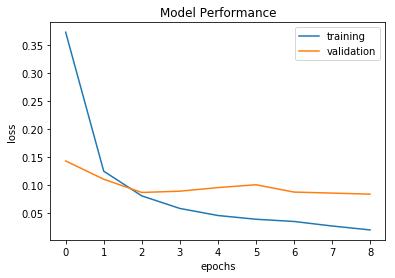

In [60]:
plot_loss(train_loss,val_loss)

### Test the performance of the model on the testing set

In [61]:
def model_test(test_data,best_parameters,sess):
    """
    Model evalution for the test set,
    params:  sess: default tensorflow session object.
             test_data: tuple of X (features) and y(labels) 
             best_parameters: final model parameters (weights).
    returns: Accuracy on the test data.

    """
    X_test, y_test = test_data

    X_in,y_in = create_model_inputs()
    keep_prob = tf.placeholder(tf.float32)
    prediction  = nn_forward_prop(X_in,best_parameters,keep_prob)

    
    label_predictions = tf.argmax(prediction,1)
    true_predictions = tf.equal(label_predictions,tf.argmax(y_in,1))
    accuracy = tf.reduce_mean(tf.cast(true_predictions,"float"))
    

    acc = sess.run(accuracy, feed_dict={X_in:X_test,y_in:y_test,keep_prob:1.0})
    
    return acc

In [62]:
print('\n**** Model testing *****')
acc = model_test(test_data,parameters,sess)
print('Accuracy on the test set: %f' %(acc))


**** Model testing *****
?
Accuracy on the test set: 0.983100
